# Exercise 3-1: One-vs-All

In this exercise, we will implement one-vs-all logistic regression to recognize hand-written digits.

## Initialize Parameters

Setup the parameters for this part of the exercise:

In [1]:
input_layer_size = 400  # 20x20 Input Images of Digits
num_labels = 10  # 10 labels, from 1 to 10

## Part 1: Loading and Visualizing Data

`ex3data1.mat` contains 5000 training samples of handwritten digits. Each sample is a 20 pixel by 20 pixel grayscale image.

In [2]:
import numpy as np
import scipy.io as sio


mat_data = sio.loadmat('ex3data1.mat')
X = mat_data['X']
y = mat_data['y'].ravel()
m, n = X.shape

Randomly select 100 samples to display:

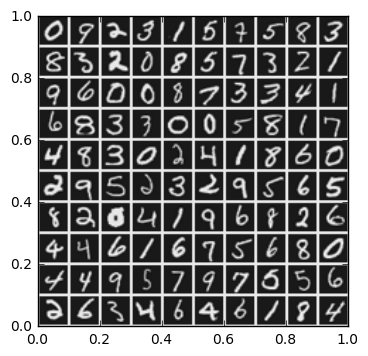

In [3]:
import matplotlib.pyplot as plt

from display_data import display_data


rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]
plt.figure()
display_data(sel, padding=1)
plt.show()

## Part 2a: Vectorize Logistic Regression

The `lrCostFunction()` provieds a vectorized implemention to compute cost and gradient.

In [4]:
def lr_cost_function(theta, X, y, l):
    """
    Compute cost and gradient for logistic regression with regularization.

    Parameters
    ----------
    theta : ndarray, shape (n_features,)
        Linear regression parameter.
    X : ndarray, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples and n_features is the number of features.
    y : ndarray, shape (n_samples,)
        Labels.
    l : float
        Regularization parameter.

    Returns
    -------
    J : numpy.float64
        The cost of using theta as the parameter for regularized logistic regression w.r.t. the parameters.
    grad : ndarray, shape (n_features,)
        Partial derivatives of the cost w.r.t. each parameter in theta.
    """
    m, n = X.shape

    mask = np.eye(len(theta))
    # Skip the theta[0, 0] parameter when performing regularization
    mask[0, 0] = 0

    X_dot_theta = X.dot(theta)

    J = 1.0 / m * (-y.T.dot(np.log(sigmoid(X_dot_theta))) - (1 - y).T.dot(np.log(1 - sigmoid(X_dot_theta)))) \
        + l / (2.0 * m) * np.sum(np.square(mask.dot(theta)))

    grad = 1.0 / m * (sigmoid(X_dot_theta) - y).T.dot(X).T + 1.0 * l / m * (mask.dot(theta))

    return J, grad


def sigmoid(z):
    """
    Compute sigmoid function.

    Parameters
    ----------
    z : array_like
        Variable for sigmoid function.

    Returns
    -------
    ndarray
        The sigmoid of each value of z.
    """
    g = 1 / (1 + np.exp(-z))
    return g

Test `lr_cost_function()`: 

In [5]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.hstack((np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F') / 10.0))
y_t = np.array([1, 0, 1, 0, 1])
lambda_t = 3

cost, grad = lr_cost_function(theta_t, X_t, y_t, lambda_t)

print 'Cost:', cost
print 'Expected cost: 2.534819'
print 'Gradients: \n', grad
print 'Expected gradients: 0.146561 -0.548558 0.724722 1.398003'

Cost: 2.53481939611
Expected cost: 2.534819
Gradients: 
[ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients: 0.146561 -0.548558 0.724722 1.398003


## Part 2b: One-vs-All Training

The `one_vs_all()` trains multiple logistic regression classifiers. 

In [6]:
import scipy.optimize as opt


def one_vs_all(X, y, num_labels, l):
    """
    Trains multiple logistic regression classifiers and returns all the classifiers in a matrix all_theta, where the
    i-th row of all_theta corresponds to the classifier for label i.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples and n_features is the number of features.
    y : ndarray, shape (n_samples,)
        Labels.
    num_labels : int
        Number of labels.
    l : float
        Regularization parameter.

    Returns
    -------
    all_theta : ndarray, shape (num_labels, n_features + 1)
         All classifiers where the i-th row of all_theta corresponds to the classifier for label i.
    """
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.hstack((np.ones((m, 1)), X))
    initial_theta = np.zeros(n + 1)

    for i in range(0, 10):
        label = 10 if i == 0 else i
        result = opt.minimize(fun=lr_cost_function, x0=initial_theta, args=(X, (y==label).astype(int), l),
                              method='TNC', jac=True)
        print 'one_vs_all(): label =', label, ', success =', result.success
        all_theta[i, :] = result.x

    return all_theta

Training one-vs-all logistic regression with the given data set may take a while.

In [7]:
l = 0.1
all_theta = one_vs_all(X, y, num_labels, l)

one_vs_all(): label = 10 , success = True
one_vs_all(): label = 1 , success = True
one_vs_all(): label = 2 , success = True
one_vs_all(): label = 3 , success = True
one_vs_all(): label = 4 , success = True
one_vs_all(): label = 5 , success = True
one_vs_all(): label = 6 , success = True
one_vs_all(): label = 7 , success = True
one_vs_all(): label = 8 , success = True
one_vs_all(): label = 9 , success = True


## Part 3: Predict for One-Vs-All

The `predict_one_vs_all()` predicts the label for a trained one-vs-all classifier.

In [8]:
def predict_one_vs_all(all_theta, X):
    """
    Predict the label for a trained one-vs-all classifier.

    Parameters
    ----------
    all_theta : ndarray, shape (num_labels, n_features + 1)
         A matrix where the i-th row is a trained logistic regression theta vector for the i-th class, where num_labels
         is the number of labels and n_features is the number of features.
    X : ndarray, shape (n_samples, n_features)
        Samples, where n_samples is the number of samples.

    Returns
    -------
    p : ndarray, shape (n_samples,)
         The prediction for X.
    """
    m, n = X.shape
    X = np.hstack((np.ones((m, 1)), X))
    p = np.argmax(X.dot(all_theta.T), axis=1)
    p[p == 0] = 10
    return p

Calculate the accuracy on training set:

In [9]:
pred = predict_one_vs_all(all_theta, X)
print 'Training Set Accuracy:', np.mean(pred == y) * 100

Training Set Accuracy: 96.46
